In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Разбор статистических критериев

# 1. Критерий Колмогорова


__Гипотеза о неизвестном законе распределения:__

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

__Статистика:__

$$
K_n = \sqrt{n} \cdot \sup_{x} \mid \hat F_n(x) - F(x) \mid
$$

При справедливости нулевой гипотезы распределение статистики $K_n$ одинаково для любого исходного непрерывного распределения.




> *тест Колмогорова на нескольких искуственных примерах.:*



In [ ]:
x = stats.norm(loc=5, scale=3).rvs(1000)  #loc и scale - мат ожидание и станд. отклонением
stats.kstest(x, 'norm', args=(x.mean(), x.std(ddof=1)))  # x.std(ddof=1) это несмещенное стандартное отклонение данных x (При вычислении стандартного отклонения по выборке есть два варианта: считать деление на n (где n - размер выборки) или на n - 1. Деление на n - 1 используется для получения несмещенной оценки стандартного отклонения и компенсирует смещение, которое может возникнуть из-за использования выборки вместо генеральной совокупности.)

KstestResult(statistic=0.018006053524972754, pvalue=0.8960701734825841, statistic_location=6.280895987912395, statistic_sign=-1)

Гипотеза о нормальности для выборки, сгенерированной из нормального распределения не отвергается. Сгенерируем выборку из равномерного распределения, а после протестируем гипотезу о нормальности.

In [ ]:
x = stats.uniform(0,1).rvs(1000)
stats.kstest(x, 'norm', args=(x.mean(), x.std(ddof=1)))

KstestResult(statistic=0.0669133661741656, pvalue=0.0002452448534192065, statistic_location=0.3026793565586122, statistic_sign=1)

Видим, что  𝑝_𝑣𝑎𝑙𝑢𝑒  очень низкое. Гипотеза о нормальности отвергается. По аналогии можно протестировать гипотезу для любого распределения.
пример с экспоненциальным распределением:

In [ ]:
x = stats.expon(scale=0.2).rvs(1000)
stats.kstest(x, 'expon', args=(0, x.mean()))

KstestResult(statistic=0.019924218253412063, pvalue=0.8144889871509039, statistic_location=0.09243876584081633, statistic_sign=-1)

Первый аргумент отвечает за loc (экспоненциальное распределение со сдвигом). Он равен нулю.



> *подгрузим данные о стоимости акций Яндекса в течение последних  10  лет.*



In [ ]:
df = pd.read_csv('/content/ynd.tsv', sep='\t')
df['fielddate'] = pd.to_datetime(df['fielddate'])
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(2291, 6)


,open,high,low,close,volume,adjusted
fielddate,,,,,,
2011-05-24,35.000000,42.009998,30.549999,38.840000,70186700.0,38.840000
2011-05-25,37.750000,37.900002,34.400002,35.000000,11761600.0,35.000000
2011-05-26,34.450001,35.450001,34.000000,34.770000,4417500.0,34.770000
2011-05-27,34.750000,35.000000,34.000000,34.450001,2006000.0,34.450001
2011-05-31,34.950001,35.369999,32.610001,33.450001,3981100.0,33.450001


Обычно финансисты работают с доходностями:

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

In [ ]:
r = (df.close.diff()/df.close.shift(1)).dropna()
r

fielddate
2011-05-25   -0.098867
2011-05-26   -0.006571
2011-05-27   -0.009203
2011-05-31   -0.029028
2011-06-01   -0.035874
                ...   
2020-06-24    0.026531
2020-06-25    0.004970
2020-06-26   -0.030069
2020-06-29    0.004283
2020-06-30    0.015841
Name: close, Length: 2290, dtype: float64

Построим график доходностей и наложим на него нормальное распределение

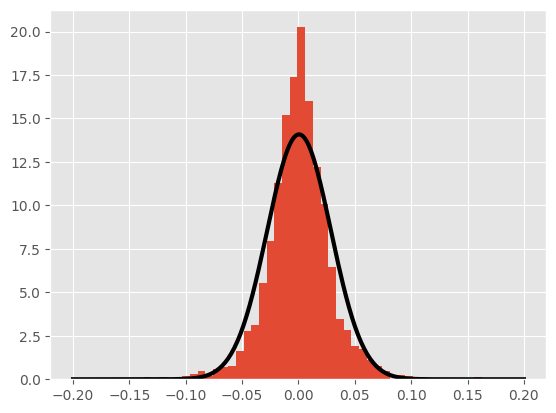

In [ ]:
r.hist(bins=50, density=True);

xs = np.linspace(-0.2, 0.2, 300)
ys = stats.norm(loc=r.mean(), scale=r.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, color="black", lw=3);

Как это не странно, оно оказывается куполообразным. Издали распределение напоминает собой нормальное. но можно заметить, что у распределения довольно тяжёлые хвосты. построим диаграмму квантиль-квантиль(сравним выборочное распределение с теоретическим.

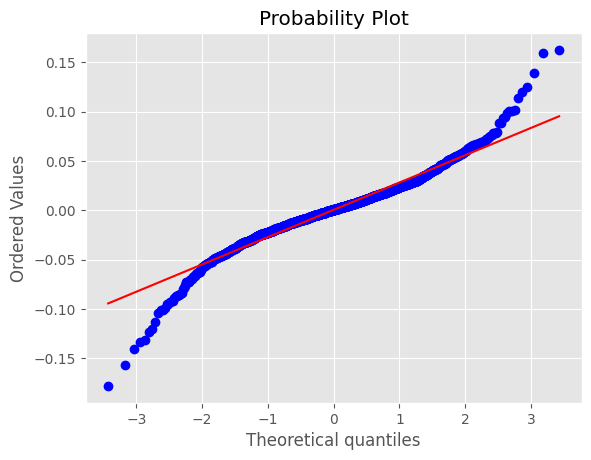

In [ ]:
stats.probplot(r, dist="norm", plot=plt);

по оси  𝑥  откладываются значения из теоретического нормального распределения.
по оси  𝑦  откладывают значения, которые фигурируют в выборке.
если бы наши наблюдения были из нормального распределения, они бы оказались на диагонали.
центр, действительно, укладывается на неё. а вот хвосты с неё спадают. Они оказываются тяжелыми.

Проверим гипотезу тестом Колмогорова.

In [ ]:
r.mean(), r.std(ddof=1)
stats.kstest(r, 'norm', args=(r.mean(), r.std(ddof=1)))

KstestResult(statistic=0.05845783509742092, pvalue=3.035955008496118e-07, statistic_location=-0.019044615018564158, statistic_sign=-1)

гипотеза о нормальности отвергается, p_value оказалось очень маленьким. Обычно доходности моделируют с помощью распределений с тяжёлыми хвостами. Попробуем проверить ту же самую гипотезу, но с помощью критерия, специфицированного под хвосты (Андерсона-Дарлинга): мы переносим на хвосты распределения дополнительный вес, чтобы критерий был к ним более чувствительным.

In [ ]:
from statsmodels.stats.diagnostic import normal_ad
pval = normal_ad(r)
pval # гипотеза о нормальности отвергается

(19.749165127467222, 0.0)

Попробуем этот же тест для выборки из нормального распределения.

In [ ]:
x = stats.norm(loc=5, scale=3).rvs(1000)
normal_ad(x)  # гипотеза о нормальности не отвергается

(0.2853290850046051, 0.6265341476695172)

полезное свойство критерия: можно ***проверять гипотезу об однородности выборок***, то есть пытаться понять из одного ли распределения они к нам пришли. Колмогоров доказал, что для этого случая распределение Колмогорова тоже подходит.

```
# Выбран кодовый формат
```



In [ ]:
x = stats.norm(loc=5, scale=3).rvs(1000)
y = stats.norm(loc=5, scale=3).rvs(1000)
z = stats.expon(scale=0.2).rvs(1000)

In [ ]:
stats.ks_2samp(x, y)

KstestResult(statistic=0.037, pvalue=0.5005673707894058, statistic_location=2.841412990490501, statistic_sign=-1)

In [ ]:
stats.ks_2samp(x, z)

KstestResult(statistic=0.916, pvalue=0.0, statistic_location=0.9058145227287282, statistic_sign=-1)

* > __заметка__  Критерий работает только для непрерывных распределений! Для дискретных ситуаций обычно используют критерий Пирсона.

# 2. Критерий Пирсона


__Гипотеза о неизвестном законе распределения:__


$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

__Статистика:__

$$
\sum_{j=1}^s \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{s - k - 1},
$$

где $\hat \theta$ - любая состоятельная оценка параметра, \\
$v_j$ - частота, с которой значение $j$ встречалось в выборке, \\
$p_j$ - теоретическая вероятность того, что выпадет значение $j$, \\
 $s$ - число значений, которые может принимать случайная величина, \\
 $k$ - размерность вектора параметров $\theta$,




> Пример (число пи) \\
В десятичной записи числа $\pi$ среди первых $10002$ знаков после запятой цифры $0, 1, \dots, 9$ встречаются соответственно 968, 1026, 1021, 974, 1014, 1046, 1021, 970, 948, 1014 раз. Можно ли при уровне значимости $0.05$ считать эти цифры случайными? При каком уровне значимости эта гипотеза отвергается?



У нас есть дискретное распределение и  10  вероятностей. Нужно проверить гипотезу о равномерности этого распределения. Будем делать это с помощью критерия Пирсона.

In [ ]:
n = 10002
X = np.array([968, 1026, 1021, 974, 1014, 1046, 1021, 970, 948, 1014])
p = X/n
p

array([0.09678064, 0.10257948, 0.10207958, 0.09738052, 0.10137972,
       0.10457908, 0.10207958, 0.0969806 , 0.09478104, 0.10137972])

In [ ]:
p0 = np.array([1/10]*10) #зададим равномерное распределение для сравнения
p0

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Статистика для теста Пирсона выглядит как

$$
\sum_{j=1}^{10} \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{9},
$$

In [ ]:
T = np.sum((X - n*p0)**2/(n*p0))
T

9.367726454709057

Статистика Пирсона имеет $\chi^2_9$. Найдём для неё критическое значения на уровне значимости $5\%$.

In [ ]:
stats.chi2.ppf(0.95, df = 9)

16.918977604620448

Наблюдаемое значение меньше критического. Гипотеза о равномерности не отвергается. Найдём  𝑝_𝑣𝑎𝑙𝑢𝑒 .

In [ ]:
1 - stats.chi2.cdf(T, df = 9)

0.4040452075150309

Видим, что  𝑝_𝑣𝑎𝑙𝑢𝑒  на порядок выше  5% , значит гипотеза не отвергается.

upd: можно легче

In [ ]:
from scipy.stats import chisquare
chisquare(X, f_exp=n*p0)

Power_divergenceResult(statistic=9.367726454709057, pvalue=0.40404520751503087)

тест Пирсона можно использовать, чтобы **проверять выборки на однородность.** В таком случае критерий хочет получить на вход таблицу сопряжённости для двух распределений.

Мужчин и женщин опрашивают о их политических взглядах. Правда ли, что их распределение значимо различается.

In [ ]:
df = pd.DataFrame([[762, 327, 468],[484, 239, 477]])
df.columns = ["Democrat","Independent", "Republican"]
df.index = ["F", "M"]
df

,Democrat,Independent,Republican
F,762,327,468
M,484,239,477


In [ ]:
df.values

array([[762, 327, 468],
       [484, 239, 477]])

In [ ]:
from scipy.stats import chi2_contingency
chi, pvalue, k, _ = chi2_contingency(df.values)

In [ ]:
chi

30.070149095754672

In [ ]:
pvalue

2.9535891832117595e-07

In [ ]:
k

2

# 3. t-критерий Стьюдента

Используется для проверки гипотезы о различии между ***средними значениями*** двух выборок

Можно применять, если:
*   данные нормальны
*   дисперсии равны


Для двух независимых выборок критерий Стьюдента имеет следующую формулу для вычисления t-статистики:

$$
 t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$
где:
- $( \bar{x}_1 )$ и $ ( \bar{x}_2 ) $- средние значения первой и второй выборок соответственно,
- $( s_1^2 )$ и $( s_2^2 )$ - несмещенные оценки дисперсии первой и второй выборок соответственно,
- $( n_1 )$ и $( n_2 )$ - размеры первой и второй выборок соответственно.

Затем, значение t-статистики сравнивается с критическим значением из распределения t-Стьюдента с $( n_1 + n_2 - 2 )$ степенями свободы (где $( n_1 + n_2 ) $- общее количество наблюдений в обеих выборках). Если вычисленное значение t-статистики больше критического значения, то различие считается статистически значимым, и гипотеза об отсутствии различий отвергается.


> Пример Критерий Стьюдента для независимых выборок. Возраст, в котором умирают европейские аристократы. =====================

Данные о возрасте, в котором умирали европейцы в середине 19 века, в зависимости от их класса (sovereignty, aristocracy, and gentry).



In [32]:
df = pd.read_csv('agedeath.dat.txt', sep='\s+', header=None, names=['group', 'age', 'index'])
df.head()

,group,age,index
0,aris,21,1
1,aris,21,2
2,aris,21,3
3,aris,21,4
4,aris,21,5


In [33]:
x = df[df['group'] == 'sovr']['age']
y = df[df['group'] == 'aris']['age']
x.name, y.name = 'sovr', 'aris'

In [35]:
# Функции определяются так.
def two_histograms(x, y):
# После определения функции полезно бывает добавить её описание в таком стиле.
# Тройные кавычки -- для обрамления многострочных строковых литералов.
    """
    Функция, которая построит две гистограммы на одной картинке.
    Дополнительно пунктирными линиями указываются средние значения выборок.
    x: вектор pd.Series,
    y: вектор pd.Series
    """
    x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
    y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])

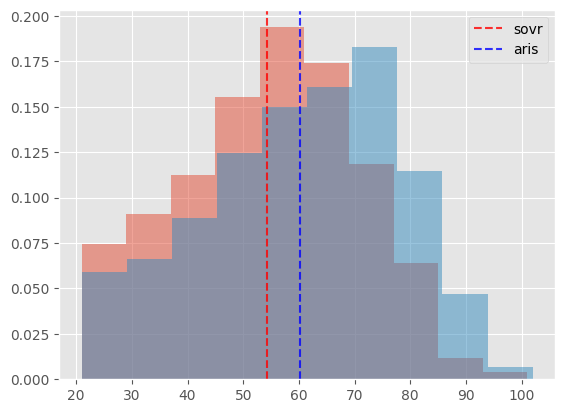

In [36]:
two_histograms(x, y)

Данные условно нормальны. Проверим c помощью критерия Флигнера-Килина, равны ли дисперсии.

In [37]:
res = stats.fligner(x, y)
print('p-value: ', res[1])

p-value:  0.00010116077103844913


Значение p-value низкое, поэтому гипотезу о равенстве дисперсий отвергаем. В двух выборках находятся разные наблюдаемые объекты, то есть выборки несвязные. Итого, гипотезу о равенстве средних значений будем проверять с помощью ttest_ind с опцией equal_var=False.

In [40]:
res = stats.ttest_ind(x, y, equal_var=False)
print('p-value: ', res[1])

p-value:  1.5181184197728794e-26


p-value < alfa, утверждение о равенстве отвергается

# 4. Критерий Уилкоксона ,Манна-Уитни


Алгоритм **Критерия Уилкоксона**  (непараметрич) \
1. Составить список испытуемых в любом порядке, например, алфавитном.
2. Вычислить разность между индивидуальными значениями во втором и первом замерах. Определить, что будет считаться типичным сдвигом.
3. Согласно алгоритму ранжирования, проранжировать абсолютные величины разностей, начисляя меньшему значению меньший ранг, и проверить совпадение полученной суммы рангов с расчётной.
4. Отметить каким-либо способом ранги, соответствующие сдвигам в нетипичном направлении. Подсчитать их сумму Т.
5. Определить критические значения Т для данного объема выборки. Если Т-эмп. меньше или равен Т-кр. – сдвиг в «типичную» сторону достоверно преобладает.

In [42]:
df_2015 = pd.read_csv("2015.csv")
df_2015.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


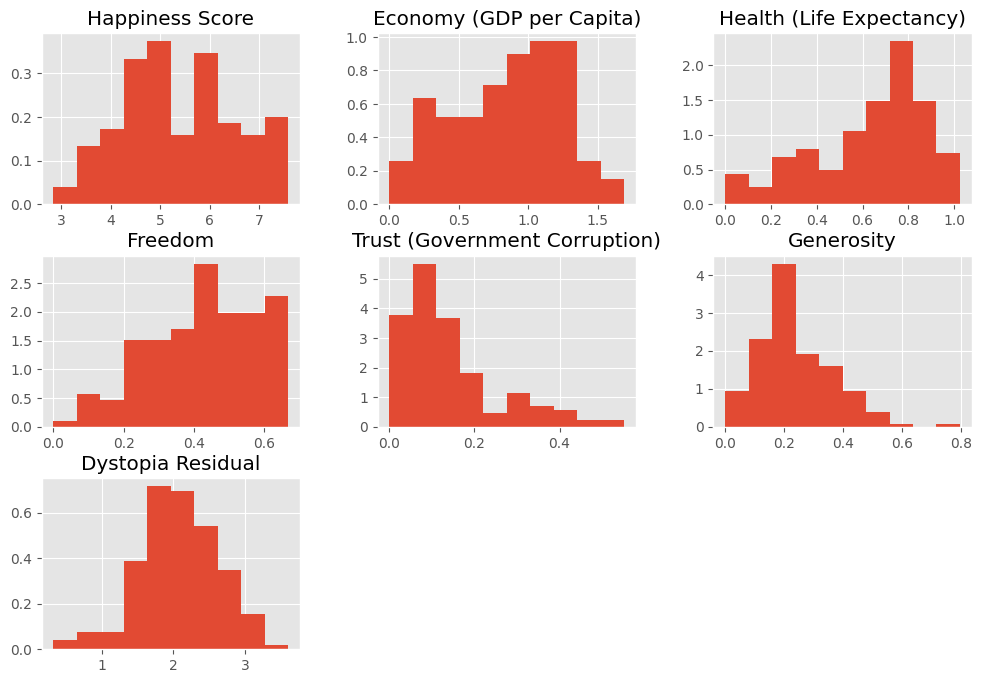

In [43]:
df_2015[['Happiness Score', 'Economy (GDP per Capita)',
         'Health (Life Expectancy)', 'Freedom',
         'Trust (Government Corruption)','Generosity',
         'Dystopia Residual']].hist(density=True, figsize=(12,8));

<ipython-input-44-a950ad75fde8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2015['Trust (Government Corruption)']);


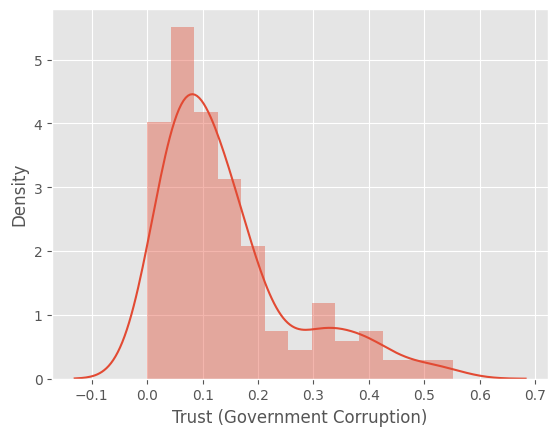

In [44]:
sns.distplot(df_2015['Trust (Government Corruption)']);

<ipython-input-45-6a2b41e5d380>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2015['Happiness Score']);


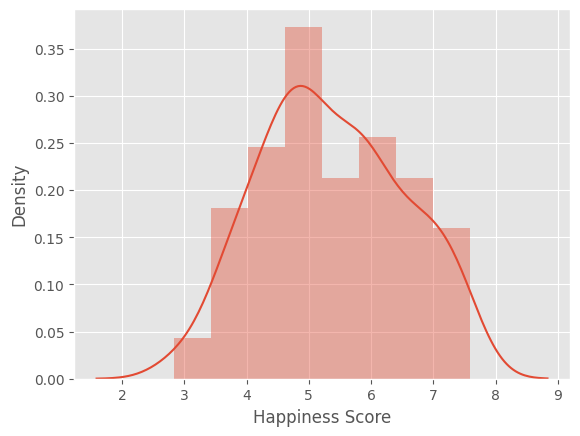

In [45]:
sns.distplot(df_2015['Happiness Score']);

> # 1. Одновыборочные критерий Уилкоксона

Проверим гипотезу о том, что медиана уровня счастья равна $5$.

$H_0\colon Med(X) = 5$

$H_1\colon Med(X) \ne 5$

In [46]:
df_2015['Happiness Score'].describe()

count    158.000000
mean       5.375734
std        1.145010
min        2.839000
25%        4.526000
50%        5.232500
75%        6.243750
max        7.587000
Name: Happiness Score, dtype: float64

In [47]:
_, pvalue = stats.wilcoxon(x - 5)
pvalue

5.775576620891091e-237

гипотеза отвергается

> # Двухвыборочные (несвязанные выборки)


Правда ли, что в Европе уровень счастья выше, чем в Азии?

In [48]:
df_2015.Region.value_counts()

Sub-Saharan Africa                 40
Central and Eastern Europe         29
Latin America and Caribbean        22
Western Europe                     21
Middle East and Northern Africa    20
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
North America                       2
Australia and New Zealand           2
Name: Region, dtype: int64

In [49]:
usl = df_2015.Region.apply(lambda w: 'Asia' in w) #объединим разные части Азии для удобства
x_asia = df_2015[usl]['Happiness Score']
x_asia.size

22

In [50]:
usl = df_2015.Region.apply(lambda w: 'Europe' in w)
x_eur = df_2015[usl]['Happiness Score']
x_eur.size

50

__Ранговый критерий Мана-Уитни__

$H_0\colon f_{X}(x) = f_{Y}(x)$

$H_1\colon f_{X}(x) = f_{Y}(x + \Delta), \Delta > 0$

In [51]:
stats.mannwhitneyu(x_eur, x_asia, alternative='greater')

MannwhitneyuResult(statistic=774.0, pvalue=0.0031457735731103722)

Гипотеза отвергается. По этим данным, в Европе люди счастливее.